In [1]:
import numpy as np
import pandas as pd
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 50, 16

## Loading data and plotting the curve

In [12]:
df = pd.read_csv("SeaPlaneTravel.csv",sep=",",header="infer")

In [13]:
df.head()

Month  #Passengers
0  2003-01          112
1  2003-02          118
2  2003-03          132
3  2003-04          129
4  2003-05          121

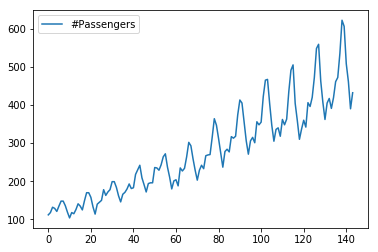

In [14]:
df.plot()
plt.show()

## Converting code to time series

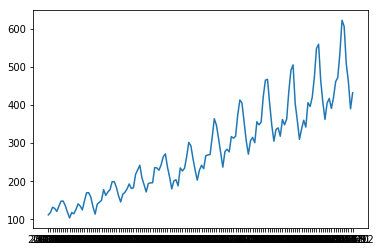

In [15]:
indexed_df = df.set_index('Month')
ts = indexed_df['#Passengers']
plt.plot(ts)
plt.show()

## Checking stationarity

In [23]:
X = ts.values
split = int(len(X)/2)

In [24]:
X1 = X[:split]
X2 = X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=182.902778, mean2=377.694444
variance1=2244.087770, variance2=7367.962191


In [27]:
### Aboive data is non stationary as mean and variance of 2 parts of data is different
### ADF tests the null hypothesis that a unit root is present in time series sample. 
''' ADF statistic is a negative number and more negative it is the stronger the rejection of 
the hypothesis that there is a unit root. '''

In [25]:
#p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
#p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary

In [28]:
def testStationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [29]:
testStationarity(ts)

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## Making data stationary by Log transforming data

In [33]:
def generateStationarity(timeseries):
    result_log = adfuller(np.log(timeseries))
    print('ADF Statistic: %f' % result_log[0])
    print('p-value: %f' % result_log[1])
    print('Critical Values:')
    for key, value in result_log[4].items():
        print('\t%s: %.3f' % (key, value))

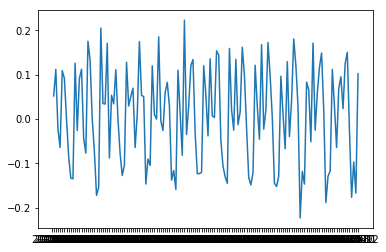

In [34]:
ts_week_log = np.log(ts)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

In [35]:
generateStationarity(ts)

ADF Statistic: -1.717017
p-value: 0.422367
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [36]:
ts_week_log_diff.dropna(inplace=True)
testStationarity(ts_week_log_diff)

ADF Statistic: -2.717131
p-value: 0.071121
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


## Plotting Autocorelation plot

In [37]:
from pandas.tools.plotting import autocorrelation_plot

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


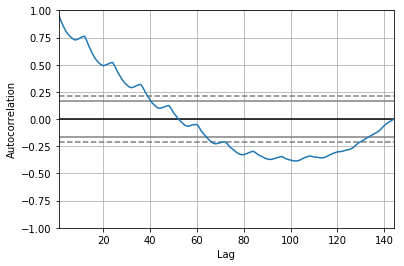

In [38]:
autocorrelation_plot(ts_week_log)
plt.show()

In [39]:
#ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

Text(0.5,1,'Autocorrelation Function')

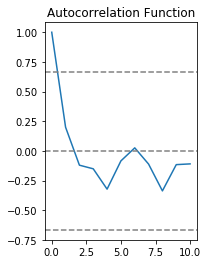

In [40]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

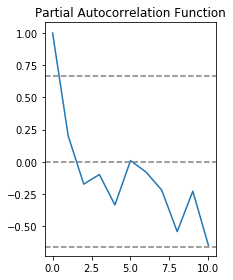

In [41]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## Creating ARIMA model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5,1,'RSS: 1.1753')

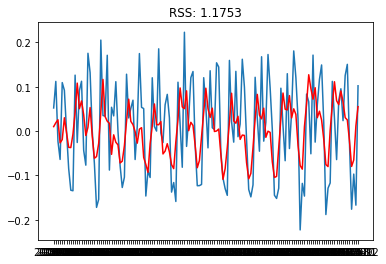

In [42]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=0)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

In [43]:
results_ARIMA

In [44]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Thu, 03 Oct 2019   AIC                           -270.151
Time:                        21:10:28   BIC                           -255.337
Sample:                             1   HQIC                          -264.131
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0101      0.000     23.505      0.000       0.009       0.011
ar.L1.D.#Passengers     0.9983      0.076     13.162      0.000       0.850       1.147
ar.L2.D.#Passeng

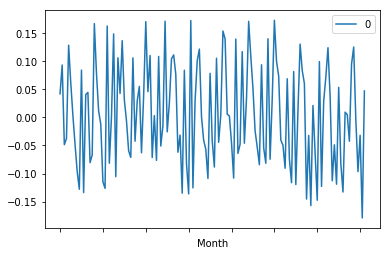

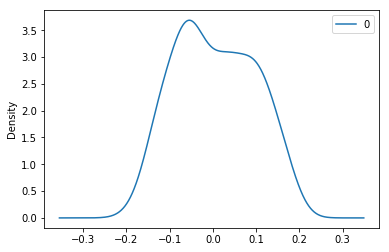

                0
count  143.000000
mean     0.005157
std      0.090830
min     -0.179038
25%     -0.065515
50%      0.003233
75%      0.082560
max      0.173153


In [45]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [46]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
2003-02    0.010077
2003-03    0.018743
2003-04    0.025562
2003-05   -0.026621
2003-06   -0.019242
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,'RMSE: 192.7173')

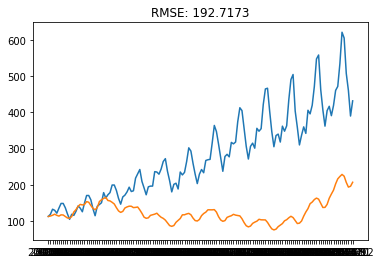

In [47]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [48]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

In [49]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=411.453675, expected=432.000000


In [50]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.008353


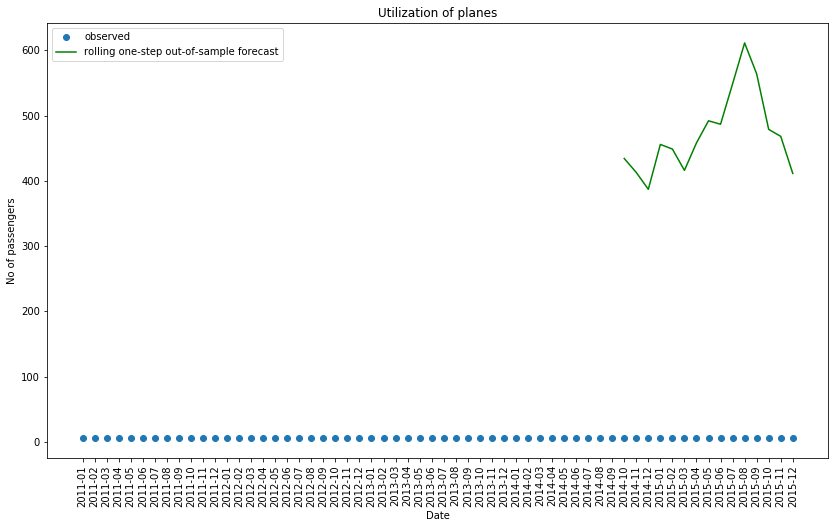

In [60]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(14)
ax.set(title='Utilization of planes', xlabel='Date', ylabel='No of passengers')
ax.plot(ts_week_log[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)